## AMAZON STOCK PRICE PREDICTON

### Time Series Analysis

Any data that collectively represents how a system/process/behaviour changes over time is known as Time Series data. Time series forecasting uses information regarding historical values and associated patterns to predict future activity. In this project, we are going to predict tomorrow's closing price of Amazon Stock (AMZN) by analysing the stock data for over a time period(3 years) until today. Predicting the performance of stock market is one of the most difficult tasks as the share prices are highly volatile for various reasons. Thus, forecasting prices with high accuracy rates is is difficult. Stock market are key to technical analysis where the approach to investing is based on cycles. If we want positive return every time whenever we do investment, we can take help of a machine learning model that can help us to look deeper into these hidden cycles in stock market. ARIMA and FBProphet are common statistical models used to predict stock prices. Also deep learning technique of RNN, specifically LSTM runs on Tensorflow background and is known to have better performance.  We shall be implementing these models and comparing the performance of each model and choose the best one. In order to handle big data and be time efficient, we shall be running this code on Spark clusters.  


### Importing the necessary Libraries

In [97]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import date
from datetime import datetime
import matplotlib.pyplot as plt
import fix_yahoo_finance as yf 
import pyspark as spark
from io import StringIO
import time, json
from datetime import date, timedelta
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
#from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.metrics import *
from matplotlib import style
import matplotlib.pylab as plt
%matplotlib inline
#from matplotlib.pylab import rcParams
import warnings
from prettytable import PrettyTable
#rcParams['figure.figsize'] = 16,8
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list, struct
from pyspark.sql.types import FloatType, StructField, StructType, StringType, TimestampType
from fbprophet import Prophet
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
import time #helper libraries
from sklearn.preprocessing import MinMaxScaler
from numpy import newaxis
#from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


### Reading Data

Data is pulled from Yahoo Finance from today's date back upto 3 years so as to take into consideration the most recent trend for better predictions.

In [2]:
# create a SparkSession using the SparkSession.builder method (that gives you access to Builder API that you use to configure the session).

spark = SparkSession.builder.getOrCreate()

In [3]:
start = datetime.now() # gets today's date
start = start.replace(year=start.year-3) # gets the date before 3 years
end = datetime.now() # gets today's date

In [4]:
def get_csv():
    amzn_data = yf.download('AMZN',start,end) # getting amazon stock from yahoo finance
    amzn_data.to_csv('AMZN.csv', index=True, header=True)
    amzn_data.Close.plot() # Plotting the close value of stocks
    plt.show()
    return;

[*********************100%***********************]  1 of 1 downloaded


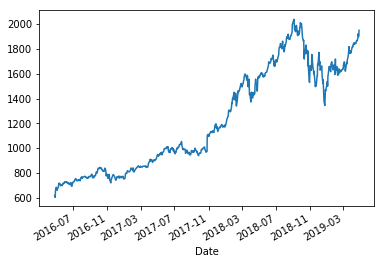

In [5]:
get_csv()

In [6]:
# create a dataframe

df = (spark.read
          .option("header", "true")
          .option("inferSchema", value=True)
          .csv("AMZN.csv"))

In [7]:
df.describe()

DataFrame[summary: string, Open: string, High: string, Low: string, Close: string, Adj Close: string, Volume: string]

In [8]:
df.head(5)

[Row(Date=datetime.datetime(2016, 4, 26, 0, 0), Open=626.169983, High=626.75, Low=614.880005, Close=616.880005, Adj Close=616.880005, Volume=2521400),
 Row(Date=datetime.datetime(2016, 4, 27, 0, 0), Open=611.799988, High=615.950012, Low=601.280029, Close=606.570007, Adj Close=606.570007, Volume=4068800),
 Row(Date=datetime.datetime(2016, 4, 28, 0, 0), Open=615.539978, High=626.799988, Low=599.200012, Close=602.0, Adj Close=602.0, Volume=7872600),
 Row(Date=datetime.datetime(2016, 4, 29, 0, 0), Open=666.0, High=669.97998, Low=654.0, Close=659.590027, Adj Close=659.590027, Volume=10310700),
 Row(Date=datetime.datetime(2016, 5, 2, 0, 0), Open=663.919983, High=685.5, Low=662.030029, Close=683.849976, Adj Close=683.849976, Volume=6578500)]

### Feature Description

The data pulled from Yahoo Finance is stored in a .csv file. The AMZN stock data has the following features:

1. Date - in format: yyyy-mm-dd
2. High - Highest price reached in the day
3. Low	 - Lowest price reached in the day
4. Open - price of the stock at market open 
5. Close - price of the stock at market close
6. Volume - Number of shares traded
7. Adj Close - stock's closing price on any given day of trading that has been amended to include any distributions and corporate actions that occurred at any time before the next day's open


In [9]:
# select only Date and Close columns which we shall be using in our model
df = df.select(
        df['Date'],
        df['Close'].cast(FloatType())
    )

In [10]:
df.head(5)

[Row(Date=datetime.datetime(2016, 4, 26, 0, 0), Close=616.8800048828125),
 Row(Date=datetime.datetime(2016, 4, 27, 0, 0), Close=606.5700073242188),
 Row(Date=datetime.datetime(2016, 4, 28, 0, 0), Close=602.0),
 Row(Date=datetime.datetime(2016, 4, 29, 0, 0), Close=659.5900268554688),
 Row(Date=datetime.datetime(2016, 5, 2, 0, 0), Close=683.8499755859375)]

In [11]:
df.select(df.Date, df.Close).show()

+-------------------+------+
|               Date| Close|
+-------------------+------+
|2016-04-26 00:00:00|616.88|
|2016-04-27 00:00:00|606.57|
|2016-04-28 00:00:00| 602.0|
|2016-04-29 00:00:00|659.59|
|2016-05-02 00:00:00|683.85|
|2016-05-03 00:00:00|671.32|
|2016-05-04 00:00:00| 670.9|
|2016-05-05 00:00:00|659.09|
|2016-05-06 00:00:00|673.95|
|2016-05-09 00:00:00|679.75|
|2016-05-10 00:00:00|703.07|
|2016-05-11 00:00:00|713.23|
|2016-05-12 00:00:00|717.93|
|2016-05-13 00:00:00|709.92|
|2016-05-16 00:00:00|710.66|
|2016-05-17 00:00:00|695.27|
|2016-05-18 00:00:00|697.45|
|2016-05-19 00:00:00|698.52|
|2016-05-20 00:00:00| 702.8|
|2016-05-23 00:00:00|696.75|
+-------------------+------+
only showing top 20 rows



In [12]:
df = df.toPandas()

In [13]:
# index the dataframe with the Date column
df.index =df['Date']

In [14]:
df.head()

,Date,Close
Date,,
2016-04-26,2016-04-26,616.880005
2016-04-27,2016-04-27,606.570007
2016-04-28,2016-04-28,602.000000
2016-04-29,2016-04-29,659.590027
2016-05-02,2016-05-02,683.849976


In [15]:
df['Date'] = pd.to_datetime(df['Date'])

indexed_df = df.set_index('Date')

In [16]:
ts = indexed_df['Close']
ts.head()

Date
2016-04-26    616.880005
2016-04-27    606.570007
2016-04-28    602.000000
2016-04-29    659.590027
2016-05-02    683.849976
Name: Close, dtype: float32

In [17]:
ts.tail(5)

Date
2019-04-22    1887.310059
2019-04-23    1923.770020
2019-04-24    1901.750000
2019-04-25    1902.250000
2019-04-26    1950.630005
Name: Close, dtype: float32

Text(0,0.5,'Close Price')

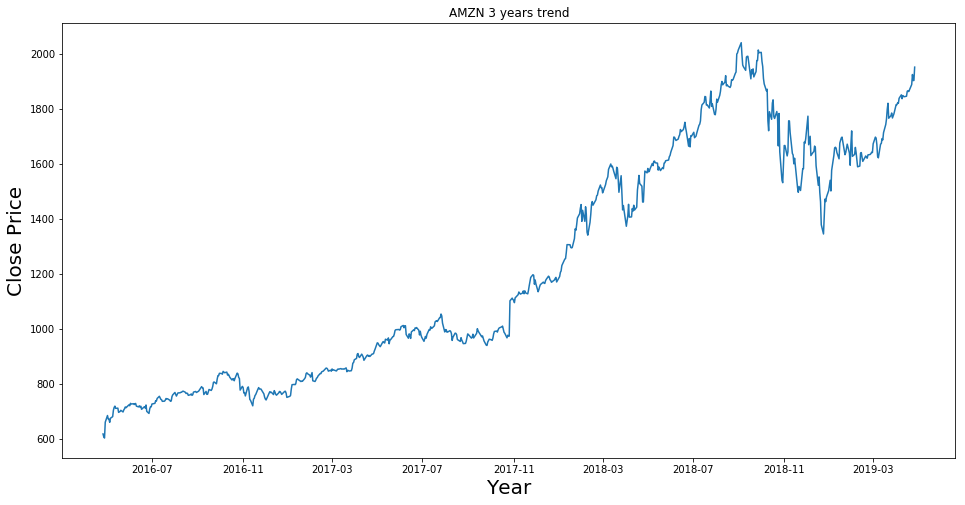

In [18]:
# visualize the time series to see how AMZN stock Close price trends over time
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.title('AMZN 3 years trend')
plt.xlabel('Year',fontsize=20)
plt.ylabel('Close Price',fontsize=20)

### Exploratory Data Analysis

### Check for Stationarity of the Time series

stationarity means that the statistical properties of a process generating a time series do not change over time. It does not mean that the series does not change over time, just that the way it changes does not itself change over time. The algebraic equivalent is thus a linear function, perhaps, and not a constant one; the value of a linear function changes as 𝒙 grows, but the way it changes remains constant.

Stationary Time Series data does not have any upward or downward trend or seasonal effects. Mean or variance are consistent over time

Non-Stationary Time Series data show trends, seasonal effects, and other structures depend on time. Forecasting performance is dependent on the time of observation. Mean and variance change over time and a drift in the model is captured.

We are using a statistical method called Dickey-Fuller test to check if our time series is stationary or not.

* In statistics, a moving average (rolling average or running average) is a calculation to analyze data points by creating a series of averages of different subsets of the full data set. It is also called a moving mean (MM) or rolling mean and is a type of finite impulse response filter.

In [19]:
from statsmodels.tsa.stattools import adfuller

In [20]:
# check for stationarity

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=52,center=False).mean() 
    rolstd = timeseries.rolling(window=52,center=False).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,8))
    orig = plt.plot(timeseries, color='green',label='AMZN Data')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.xlabel('Time(Days)',fontsize=15)
    plt.ylabel('Price($)',fontsize=15)
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

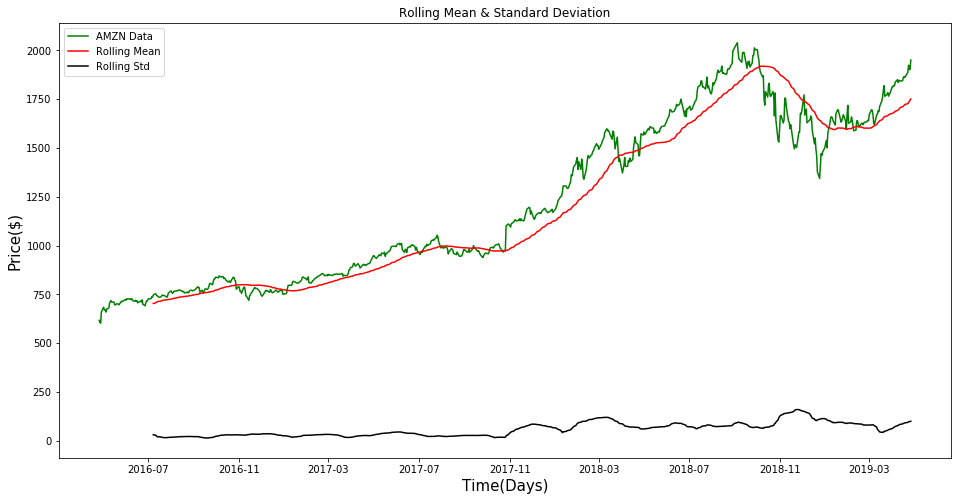

Results of Dickey-Fuller Test:
Test Statistic                  -0.232047
p-value                          0.934592
#Lags Used                       8.000000
Number of Observations Used    747.000000
Critical Value (1%)             -3.439134
Critical Value (5%)             -2.865417
Critical Value (10%)            -2.568834
dtype: float64


In [21]:
test_stationarity(ts)

Because the test statistic is more than the 5% critical value and the p-value is larger than 0.05, the moving average is not constant over time and the null hypothesis of the Dickey-Fuller test cannot be rejected. This shows that the weekly time series is not stationary. Transform this time series into a stationary time series before fitting to the models.

In [22]:
# apply a non linear log transform

ts_log = np.log(ts)

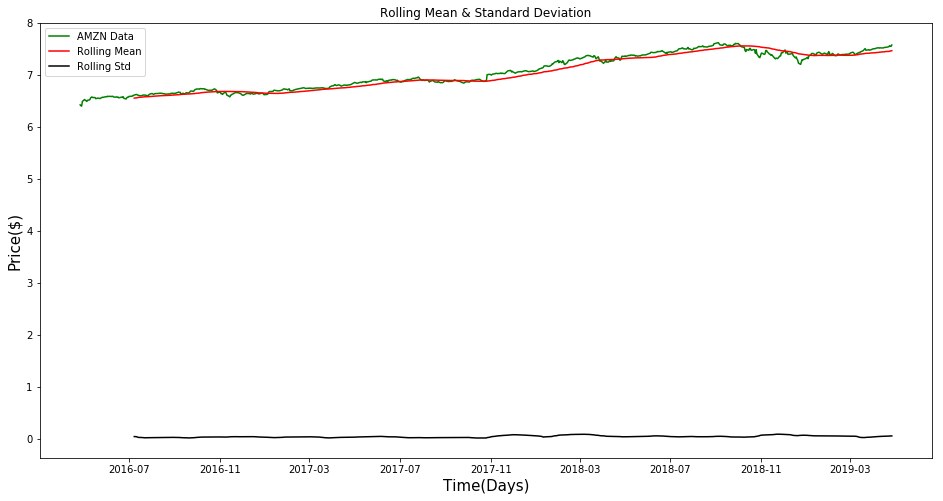

Results of Dickey-Fuller Test:
Test Statistic                  -1.035067
p-value                          0.740261
#Lags Used                       0.000000
Number of Observations Used    755.000000
Critical Value (1%)             -3.439041
Critical Value (5%)             -2.865376
Critical Value (10%)            -2.568813
dtype: float64


In [23]:
test_stationarity(ts_log)

The Dickey-Fuller test results confirm that the series is still non-stationary. Again the test statistic is larger than the 5% critical value and the p-value larger than 0.05

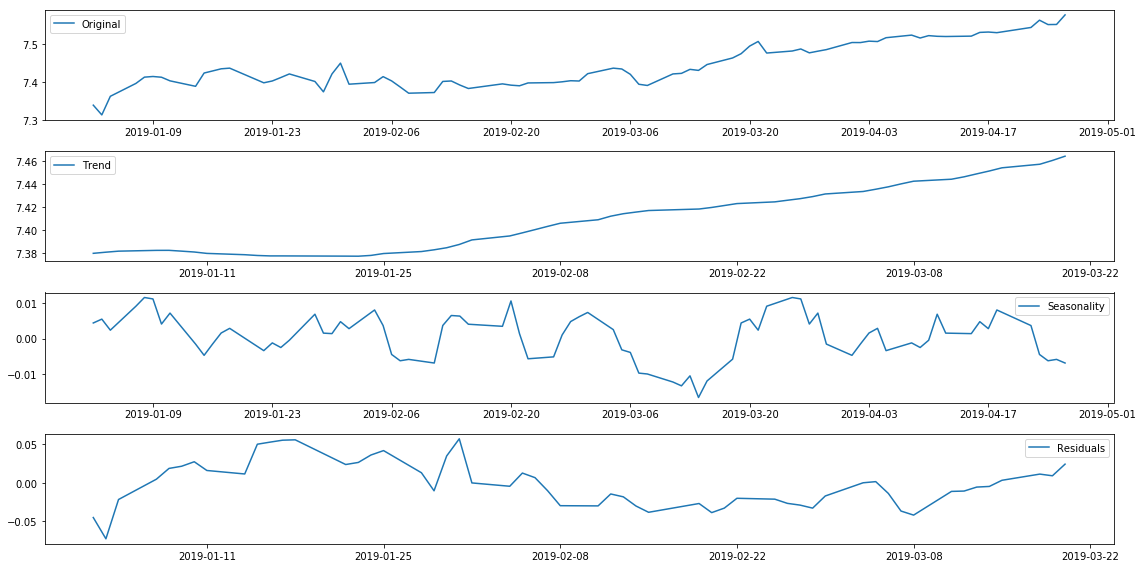

In [24]:
# remove trend and seasonality with decomposition

decomposition = seasonal_decompose(ts_log, freq = 52)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16,8))
plt.subplot(411)
plt.plot(ts_log[-80:], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend[-80:], label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal[-80:],label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual[-80:], label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Time series are stationary if they do not have trend or seasonal effects. We are going to use the difference transform to remove the time series' dependence on time.

Text(0.5,1,'Seasonality')

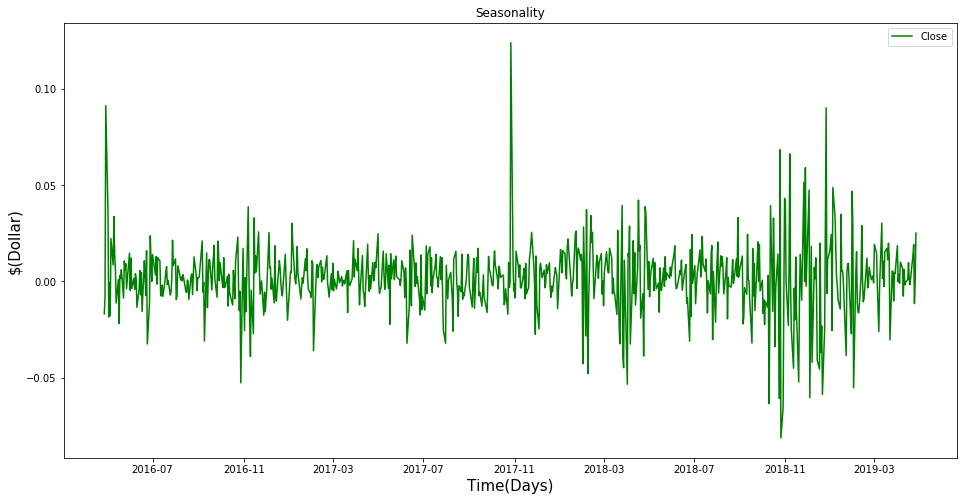

In [25]:
# remove trend and seasonality with differencing
ts_log_diff = ts_log - ts_log.shift()
plt.figure(figsize=(16,8))
plt.plot(ts_log_diff,color='green')
plt.legend(loc='best')
plt.xlabel('Time(Days)',fontsize=15)
plt.ylabel('$(Dollar)',fontsize=15)
plt.title('Seasonality')

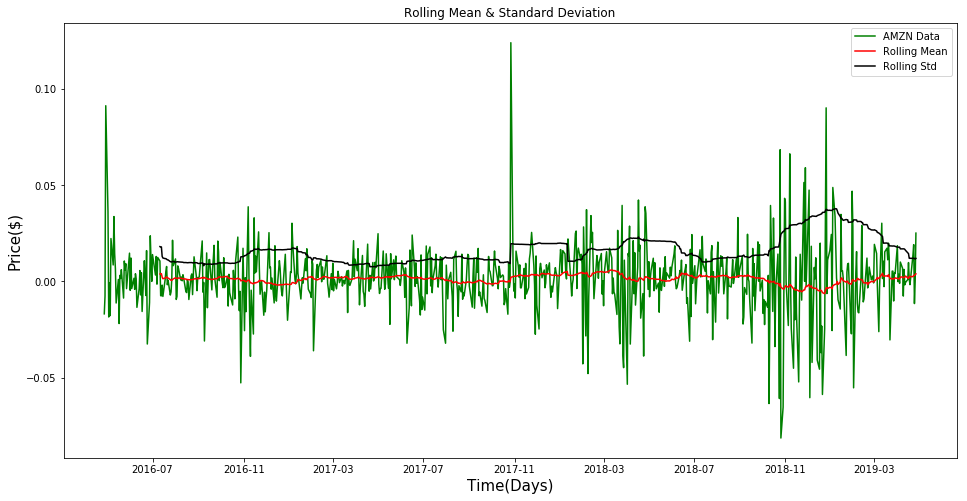

Results of Dickey-Fuller Test:
Test Statistic                -1.110267e+01
p-value                        3.830629e-20
#Lags Used                     7.000000e+00
Number of Observations Used    7.470000e+02
Critical Value (1%)           -3.439134e+00
Critical Value (5%)           -2.865417e+00
Critical Value (10%)          -2.568834e+00
dtype: float64


In [26]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

The above graph shows how the rolling mean and rolling standard deviation are comparitively consistent over time after the time series transformation. We can proceed to use this transformed data for training our  models and forecasting the stock price.


### Part A

### ARIMA


An autoregressive integrated moving average model is a form of regression analysis that gauges the strength of one dependent variable relative to other changing variables. The model's goal is to predict future securities or financial market moves by examining the differences between values in the series instead of through actual values.

The componenets of ARIMA model are
1. Autoregression (AR) refers to a model that shows a changing variable that regresses on its own lagged, or prior, values
2. Integrated (I) represents the differencing of raw observations to allow for the time series to become stationary, i.e., data values are replaced by the difference between the data values and the previous values
3. Moving average (MA) incorporates the dependency between an observation and a residual error from a moving average model applied to lagged observations

Each of the above component functions as a parameter with the standard notation of ARIMA(p,d,q) which is defined as
1. p: the number of lag observations in the model; also known as the lag order
2. d: the number of times that the raw observations are differenced; also known as the degree of differencing
3. q: the size of the moving average window; also known as the order of the moving average

In [27]:
size = int(len(ts_log)*(0.7))
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,1)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


predicted=1632.663588, expected=1641.539673
predicted=1644.849398, expected=1665.270264


C:\Users\Dt\Anaconda3\lib\site-packages\scipy\signal\signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]


predicted=1669.031243, expected=1696.349731
predicted=1700.489369, expected=1695.749634
predicted=1698.820269, expected=1689.300415
predicted=1692.183737, expected=1683.989990
predicted=1686.888445, expected=1689.119995
predicted=1692.374842, expected=1698.749756
predicted=1702.171907, expected=1704.860229
predicted=1708.177573, expected=1723.859619
predicted=1727.675974, expected=1715.970093
predicted=1718.848621, expected=1723.789795
predicted=1727.231550, expected=1734.779907
predicted=1738.342584, expected=1750.079956
predicted=1753.834203, expected=1730.219727
predicted=1732.758222, expected=1715.669922
predicted=1718.333175, expected=1663.149902
predicted=1664.222501, expected=1691.089600
predicted=1695.054875, expected=1660.510376
predicted=1662.555927, expected=1701.450073
predicted=1705.536674, expected=1699.799927
predicted=1702.807793, expected=1713.780273
predicted=1717.218071, expected=1693.960327
predicted=1696.556376, expected=1699.730225
predicted=1702.922213, expected=

C:\Users\Dt\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1908.908648, expected=1902.899658
predicted=1906.440820, expected=1905.390137
predicted=1909.027222, expected=1927.680176
predicted=1931.764044, expected=1932.819824
predicted=1936.583531, expected=1998.100464
predicted=2003.259742, expected=2002.380127
predicted=2006.348924, expected=2012.709961
predicted=2016.846228, expected=2039.509888
predicted=2044.053434, expected=1994.819824
predicted=1997.940399, expected=1958.310425
predicted=1961.291501, expected=1952.069458
predicted=1955.639617, expected=1939.010254
predicted=1942.361876, expected=1987.149902
predicted=1991.956670, expected=1990.000244
predicted=1993.847978, expected=1989.870239
predicted=1993.669983, expected=1970.189575
predicted=1973.515575, expected=1908.030396
predicted=1910.081067, expected=1941.050049
predicted=1945.333732, expected=1926.420410
predicted=1929.710757, expected=1944.299683
predicted=1948.239666, expected=1915.009644
predicted=1918.048669, expected=1934.359619
predicted=1938.245407, expected=

C:\Users\Dt\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1645.675681, expected=1663.540161
predicted=1665.811400, expected=1658.380249
predicted=1660.945359, expected=1591.909790
predicted=1594.958937, expected=1520.909912
predicted=1523.006422, expected=1551.479614
predicted=1553.478550, expected=1495.080200
predicted=1497.571582, expected=1460.829712
predicted=1462.852852, expected=1377.449951
predicted=1378.787036, expected=1343.960083
predicted=1345.132180, expected=1470.899902
predicted=1472.797425, expected=1461.640015
predicted=1463.552028, expected=1478.019897
predicted=1479.881801, expected=1501.969849
predicted=1503.882414, expected=1539.130005
predicted=1541.163951, expected=1500.279907
predicted=1502.431881, expected=1575.389771
predicted=1576.768140, expected=1629.510132
predicted=1631.675980, expected=1656.579834
predicted=1658.969597, expected=1659.420410
predicted=1661.833145, expected=1656.219604
predicted=1658.623868, expected=1640.560059
predicted=1642.920897, expected=1617.210083
predicted=1619.482776, expected=

C:\Users\Dt\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1783.302736, expected=1814.189575
predicted=1816.762543, expected=1813.980225
predicted=1816.641340, expected=1820.699707
predicted=1823.356639, expected=1818.859985
predicted=1821.532770, expected=1837.279541
predicted=1839.940548, expected=1849.860107
predicted=1852.572666, expected=1835.839844


C:\Users\Dt\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


predicted=1838.586558, expected=1847.330200
predicted=1850.027714, expected=1844.070435
predicted=1846.802553, expected=1843.060303
predicted=1845.778646, expected=1844.869873
predicted=1847.580454, expected=1863.040161
predicted=1865.744648, expected=1864.819458
predicted=1867.578992, expected=1861.690308
predicted=1864.453547, expected=1887.309814
predicted=1890.042685, expected=1923.770264
predicted=1926.599743, expected=1901.750366
predicted=1904.683062, expected=1902.250000
predicted=1905.101753, expected=1950.630005
0.9177767991455493


Printing Mean Squared Error of Predictions...
Test MSE: 0.000519


In [28]:
predictions_series = pd.Series(predictions, index = test.index)

<Figure size 1440x1440 with 0 Axes>

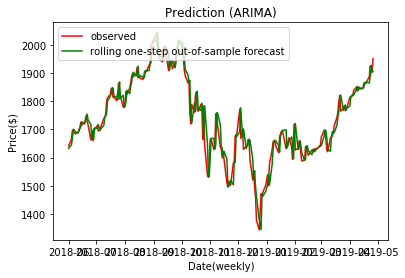

In [29]:
plt.figure(figsize=(20,20))
fig, ax = plt.subplots()
ax.set(title='Prediction (ARIMA)', xlabel='Date(weekly)', ylabel='Price($)')
ax.plot((np.exp(test)), label='observed', color='r')
ax.plot(np.exp(predictions_series), color='g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [30]:
r2

0.9177767991455493

The above model was run with values of parameters (p,d,q) set randomly as (0,1,1). The model performs with an accuracy of 91.7%. We need to tune the parameters to get the best combination of (p,d,q) to see if the model performs better.

### Tuning hyper parameters for ARIMA model

We are evaluating combinations of p, d and q values for ARIMA model to find the best combination of p, d, q values for our model

In [31]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

order=(2,1,1)
# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    X = X.astype('float32')
    train_size = int(len(X) * 0.50)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        # model_fit = model.fit(disp=0)
        model_fit = model.fit(trend='nc', disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, (order))
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s RMSE=%.3f' % (order,mse))
                except:
                    continue
    #print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(ts_log, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=3.680
ARIMA(0, 1, 1) RMSE=0.022
ARIMA(0, 1, 2) RMSE=0.022
ARIMA(0, 1, 3) RMSE=0.022
ARIMA(0, 1, 4) RMSE=0.022
ARIMA(0, 2, 1) RMSE=0.021
ARIMA(0, 2, 2) RMSE=0.022
ARIMA(1, 0, 0) RMSE=0.021
ARIMA(1, 1, 0) RMSE=0.022
ARIMA(1, 2, 0) RMSE=0.027
ARIMA(2, 1, 0) RMSE=0.022
ARIMA(2, 2, 0) RMSE=0.025
ARIMA(2, 2, 1) RMSE=0.022
ARIMA(3, 1, 0) RMSE=0.022
ARIMA(3, 1, 1) RMSE=0.022
ARIMA(3, 2, 0) RMSE=0.025
ARIMA(3, 2, 1) RMSE=0.022
ARIMA(3, 2, 2) RMSE=0.022
ARIMA(4, 1, 0) RMSE=0.022
ARIMA(4, 2, 0) RMSE=0.024
ARIMA(4, 2, 1) RMSE=0.022


#### The combination of p,d,q values for which the RMSE is lowest is chosen as the best combination. In our case, there are a couple of combinations with least RMSE of 0.021 and we will be comparing the accuracy of the corresponding model, to find the best one.

#### 1. Order = (0,2,1)

In [32]:
size = int(len(ts_log)*(0.7))
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

print('Printing Predicted vs Expected Values...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order=(0,2,1)) #The order(p,d,q) of the model
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()[0]
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

    
error = mean_squared_error(test, predictions)
r2 = r2_score(test, predictions)
print(r2)

print('\n')
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)

Printing Predicted vs Expected Values...


predicted=1633.336377, expected=1641.539673
predicted=1645.333383, expected=1665.270264
predicted=1669.252781, expected=1696.349731
predicted=1700.603221, expected=1695.749634
predicted=1700.028719, expected=1689.300415
predicted=1693.498357, expected=1683.989990
predicted=1688.105032, expected=1689.119995
predicted=1693.238700, expected=1698.749756
predicted=1702.930060, expected=1704.860229
predicted=1709.078464, expected=1723.859619
predicted=1728.217637, expected=1715.970093
predicted=1720.269062, expected=1723.789795
predicted=1728.110735, expected=1734.779907
predicted=1739.174460, expected=1750.079956
predicted=1754.592624, expected=1730.219727
predicted=1734.568444, expected=1715.669922
predicted=1719.838449, expected=1663.149902
predicted=1666.850780, expected=1691.089600
predicted=1694.888378, expected=1660.510376
predicted=1664.103229, expected=1701.450073
predicted=1705.275968, expected=1699.799927
predicted=1703.661339, expected=1

predicted=1641.816664, expected=1639.830322
predicted=1640.547352, expected=1671.729736
predicted=1672.589148, expected=1696.170166
predicted=1697.179632, expected=1692.430420
predicted=1693.448492, expected=1668.950073
predicted=1669.840495, expected=1625.949829
predicted=1626.599656, expected=1620.799927
predicted=1621.357880, expected=1670.619751
predicted=1671.394744, expected=1673.099854
predicted=1673.946416, expected=1690.809814
predicted=1691.732364, expected=1686.219727
predicted=1687.138463, expected=1712.359741
predicted=1713.385008, expected=1742.150146
predicted=1743.348675, expected=1761.849976
predicted=1763.171909, expected=1797.270264
predicted=1798.783060, expected=1819.259888
predicted=1820.920439, expected=1764.770142
predicted=1766.176878, expected=1774.260010
predicted=1775.631336, expected=1783.760010
predicted=1785.176874, expected=1765.700195
predicted=1767.030354, expected=1773.420044
predicted=1774.754068, expected=1780.749878
predicted=1782.122516, expected=

In [33]:
predictions_series = pd.Series(predictions, index = test.index)

<Figure size 1152x576 with 0 Axes>

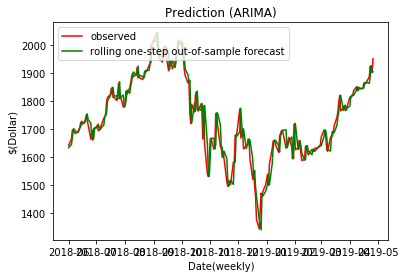

In [34]:
plt.figure(figsize=(16,8))
fig, ax = plt.subplots()
ax.set(title='Prediction (ARIMA)', xlabel='Date(weekly)', ylabel='$(Dollar)')
ax.plot((np.exp(test)), label='observed', color='r')
ax.plot(np.exp(predictions_series), color='g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [35]:
r2

0.9177671592302777

#### Accuracy for Order = (0,2,1) is 91.7%

#### 2. Order = (1,0,0)

In [36]:
predictions_series = pd.Series(predictions, index = test.index)

<Figure size 1152x576 with 0 Axes>

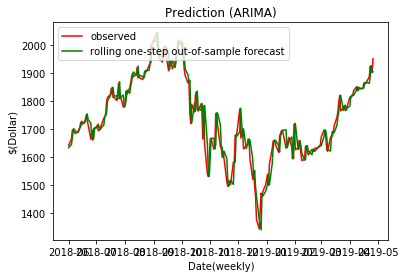

In [37]:
plt.figure(figsize=(16,8))
fig, ax = plt.subplots()
ax.set(title='Prediction (ARIMA)', xlabel='Date(weekly)', ylabel='$(Dollar)')
ax.plot((np.exp(test)), label='observed', color='r')
ax.plot(np.exp(predictions_series), color='g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')

In [38]:
r2

0.9177671592302777

#### Accuracy for Order = (1,0,0) = 91.8%



### Observations

The above graph represents the comparison of our observed stock close prices vs forecasted close price for the upcoming week with an accuracy of 91.8%


In [39]:
from prettytable import PrettyTable

In [40]:
result_hyperparam = PrettyTable()

result_hyperparam.field_names = ["Model(ARIMA(p,d,q))", "Accuracy"]

result_hyperparam.add_row(['ARIMA(0,1,1)',91.7])
result_hyperparam.add_row(['ARIMA(0,2,1)',91.7])
result_hyperparam.add_row(['ARIMA(1,0,0)',91.80])


print(result_hyperparam)

+---------------------+----------+
| Model(ARIMA(p,d,q)) | Accuracy |
+---------------------+----------+
|     ARIMA(0,1,1)    |   91.7   |
|     ARIMA(0,2,1)    |   91.7   |
|     ARIMA(1,0,0)    |   91.8   |
+---------------------+----------+


In [41]:
result_predictedvsexpected = PrettyTable()

result_predictedvsexpected.field_names = ["Date", "ARIMA_Predicted","ARIMA_Actual"]

result_predictedvsexpected.add_row(['2019-04-22',1861.05,1887.31])
result_predictedvsexpected.add_row(['2019-04-23',1886.67,1923.77])
result_predictedvsexpected.add_row(['2019-04-24',1923.12,1901.75])
result_predictedvsexpected.add_row(['2019-04-25',1901.11,1902.25])
result_predictedvsexpected.add_row(['2019-04-26',1901.61,1946.19])

print(result_predictedvsexpected)

+------------+-----------------+--------------+
|    Date    | ARIMA_Predicted | ARIMA_Actual |
+------------+-----------------+--------------+
| 2019-04-22 |     1861.05     |   1887.31    |
| 2019-04-23 |     1886.67     |   1923.77    |
| 2019-04-24 |     1923.12     |   1901.75    |
| 2019-04-25 |     1901.11     |   1902.25    |
| 2019-04-26 |     1901.61     |   1946.19    |
+------------+-----------------+--------------+


### Part 2

### Fb Prophet

We use a decomposable time series model with three main model components: trend, seasonality, and holidays. They are combined in the following equation:

y(t)= g(t)+s(t)+h(t)+εt

g(t): piecewise linear or logistic growth curve for modelling non-periodic changes in time series

s(t): periodic changes (e.g. weekly/yearly seasonality)

h(t): effects of holidays (user provided) with irregular schedules

εt: error term accounts for any unusual changes not accommodated by the model



#### Trend

Trend is modelled by fitting a piece wise linear curve over the trend or the non-periodic part of the time series. The linear fitting exercise ensures that it is least affected by spikes/missing data.

#### Seasonalities

The different seasonalities are yearly_seasonality, weekly_seasonality & daily_seasonality and they can take values as True, False.The fourier order N that defines whether high frequency changes are allowed to be modelled is an important parameter to set here. For a time series, if the user believes the high frequency components are just noise and should not be considered for modelling, he/she could set the values of N from to a lower value. If not, N can be tuned to a higher value and set using the forecast accuracy. If the value is True, default number of fourier terms (10) are taken. Prior scales are defined to tell the model how strongly it needs to consider the seasonal/holiday components while fitting and forecasting.

In [42]:
length = len(df)

In [43]:
df

,Date,Close
Date,,
2016-04-26,2016-04-26,616.880005
2016-04-27,2016-04-27,606.570007
2016-04-28,2016-04-28,602.000000
2016-04-29,2016-04-29,659.590027
2016-05-02,2016-05-02,683.849976
2016-05-03,2016-05-03,671.320007
2016-05-04,2016-05-04,670.900024
2016-05-05,2016-05-05,659.090027
2016-05-06,2016-05-06,673.950012


In [44]:
data = df
data['ds'] = df['Date']
data['y'] = df['Close']

In [45]:
data = data.drop(columns=['Date', 'Close'])

In [46]:
train = data[0:length-7]

In [47]:
train.head(5)

,ds,y
Date,,
2016-04-26,2016-04-26,616.880005
2016-04-27,2016-04-27,606.570007
2016-04-28,2016-04-28,602.000000
2016-04-29,2016-04-29,659.590027
2016-05-02,2016-05-02,683.849976


In [48]:
model = Prophet(yearly_seasonality = True, weekly_seasonality= False, seasonality_prior_scale=0.1) # Defining the model
model.fit(train) # fit data to model
future = model.make_future_dataframe(periods=7)#it creates  rows 
forecast = model.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [49]:
forecast.shape

(756, 16)

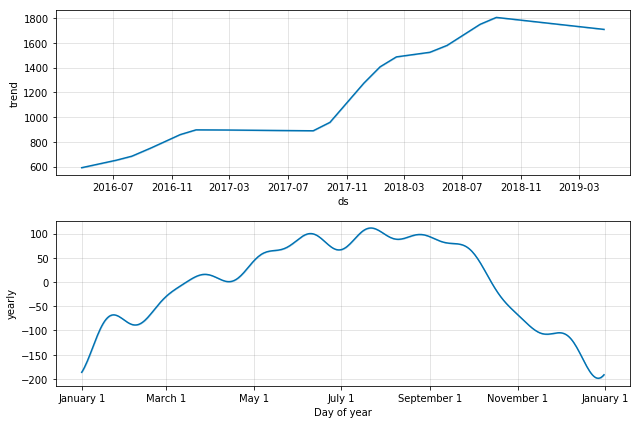

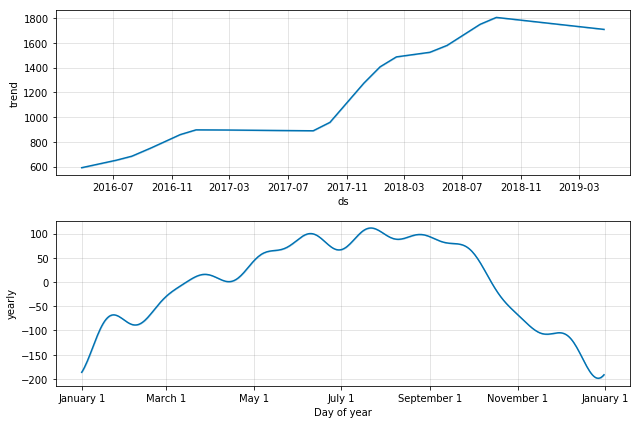

In [50]:
 # Display different components

model.plot_components(forecast)

#### Holidays and events

Holidays and events incur predictable shocks to a time series. For instance, Prime Day occurs once in every year and a large portion of the population buy a lot of items during this period. So, the sales will increase for Amazon.

#### Let's add holidays and events to our model 

We are adding Long weekends and Amazon Prime days to the model

In [51]:
# Defining Amazon prime days
primedays = pd.DataFrame({
               'holiday':'primeday', 
               'ds' : pd.to_datetime(['2016-06-12', '2017-06-10','2018-06-20']),
               'lower_window': -1,
               'upper_window': 1,
})

In [52]:
# Defining Long weekends
longweekends = pd.DataFrame({
               'holiday':'longweekend', 
               'ds' : pd.to_datetime(['2016-05-10', '2017-03-15','2018-04-21']),  
               'lower_window': -1,
               'upper_window': 1,
})

In [53]:
primedays

,holiday,ds,lower_window,upper_window
0,primeday,2016-06-12,-1,1
1,primeday,2017-06-10,-1,1
2,primeday,2018-06-20,-1,1


In [54]:
longweekends

,holiday,ds,lower_window,upper_window
0,longweekend,2016-05-10,-1,1
1,longweekend,2017-03-15,-1,1
2,longweekend,2018-04-21,-1,1


Combining both prime and long weekend in to holidays dataframe

In [55]:
holidays = pd.concat((primedays, longweekends))

In [56]:
holidays.index = holidays['ds']

In [57]:
holidays

,holiday,ds,lower_window,upper_window
ds,,,,
2016-06-12,primeday,2016-06-12,-1,1
2017-06-10,primeday,2017-06-10,-1,1
2018-06-20,primeday,2018-06-20,-1,1
2016-05-10,longweekend,2016-05-10,-1,1
2017-03-15,longweekend,2017-03-15,-1,1
2018-04-21,longweekend,2018-04-21,-1,1


#### Fit the model with holidays

In [58]:
m = Prophet(yearly_seasonality = True,holidays= holidays) # Creating the model
m.fit(train) # fit data to model
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [59]:
forecast.shape

(756, 28)

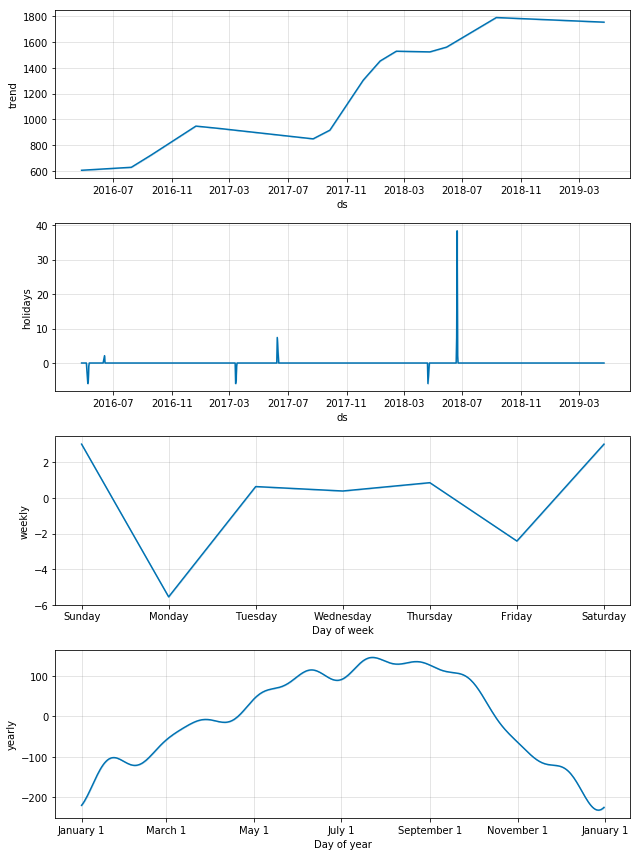

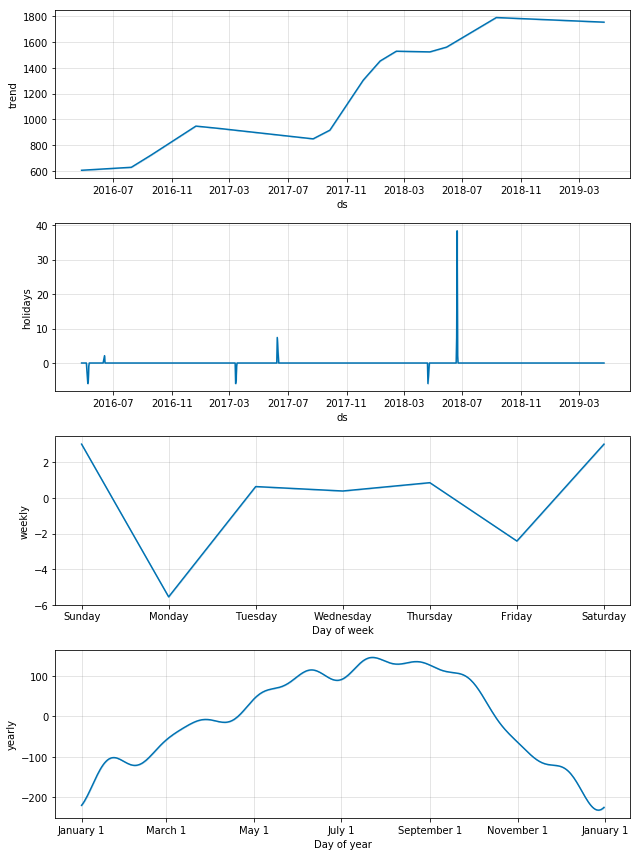

In [60]:
m.plot_components(forecast) # displays the different components

#### Forecasting values for next 7 days 

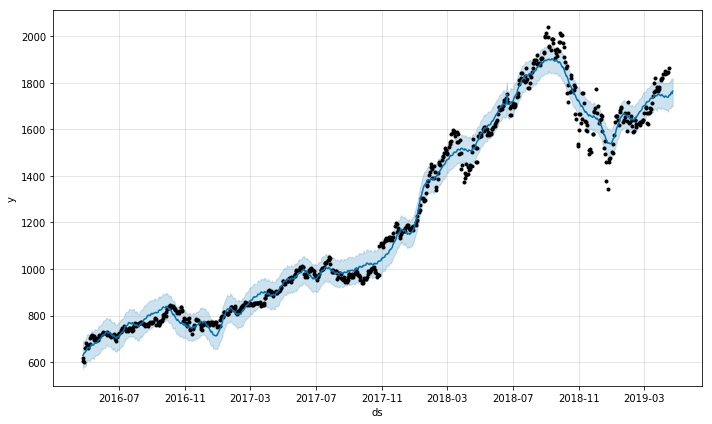

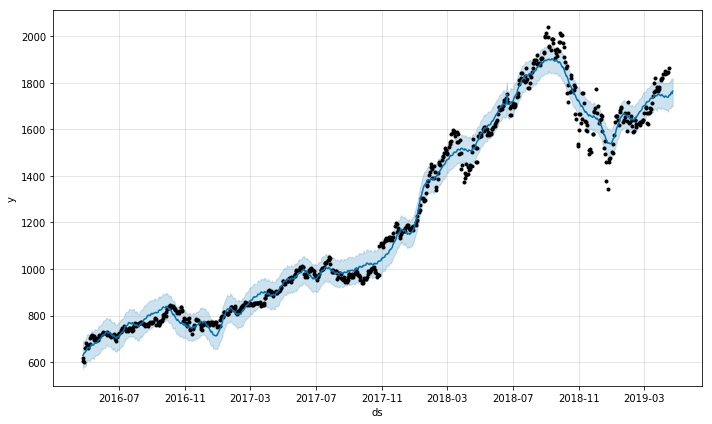

In [61]:
m.plot(forecast)

#### Tuning HyperParameters

**Trend parameters**

* growth -	linear’ or ‘logistic’ to specify a linear or logistic trend
* changepoints - List of dates at which to include potential changepoints (automatic if not specified)
* n_changepoints -	If changepoints in not supplied, you may provide the number of changepoints to be automatically included
* changepoint_prior_scale -	Parameter for changing flexibility of automatic changepoint selection

**Seasonality & Holiday Parameters**

* yearly_seasonality -	Fit yearly seasonality
* weekly_seasonality -	Fit weekly seasonality
* daily_seasonality -	Fit daily seasonality
* holidays -	Feed dataframe containing holiday name and date
* seasonality_prior_scale -	Parameter for changing strength of seasonality model
* holiday_prior_scale -	Parameter for changing strength of holiday model

#### 1. n_changepoints = 5, changepoint_prior_scale = 0.05, seasonality_prior_scale=0.95, fourier_order=20

In [62]:
m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.95, 
            changepoint_prior_scale=0.05, n_changepoints=5,
            holidays= holidays) # Creating the model 
m.add_seasonality('monthly',period=30.5,fourier_order=20)
m.add_country_holidays(country_name='US')
m.fit(train) # fit data to model 
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


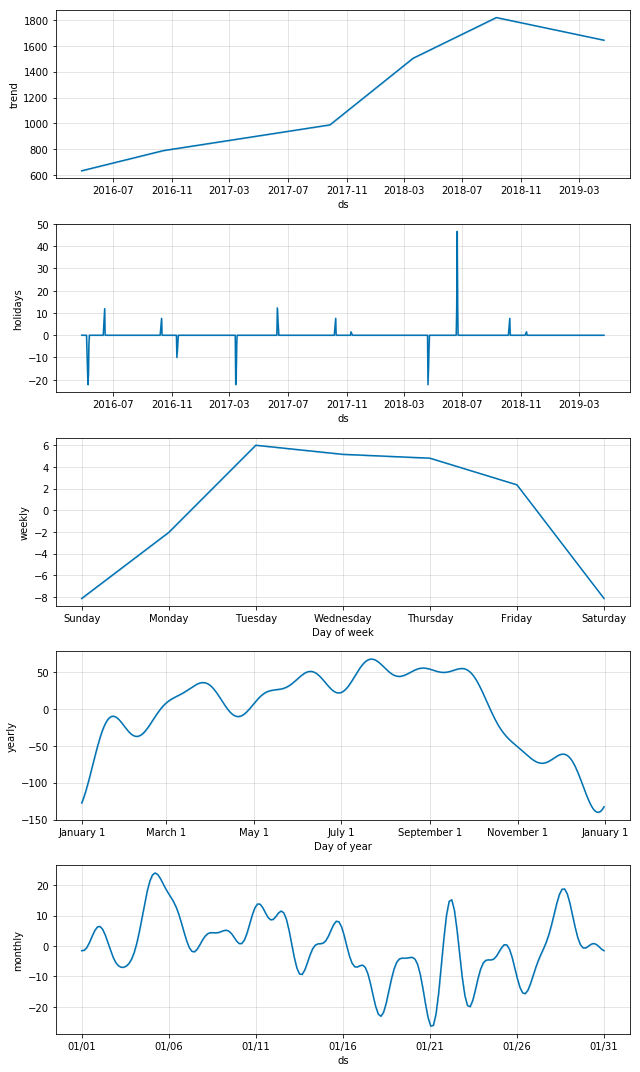

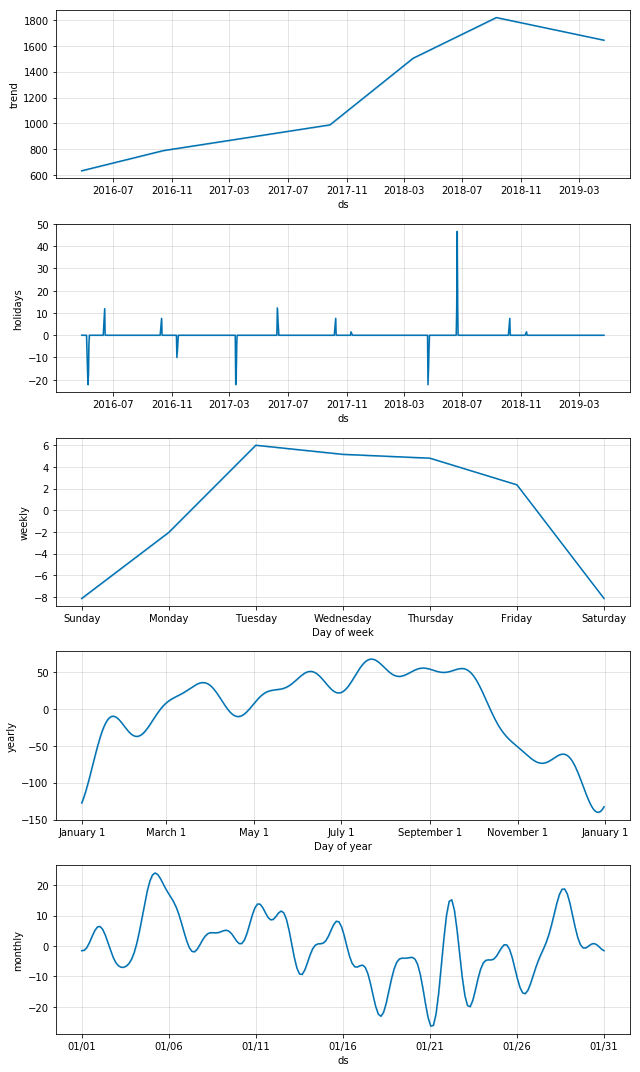

In [63]:
m.plot_components(forecast) # displays the different components

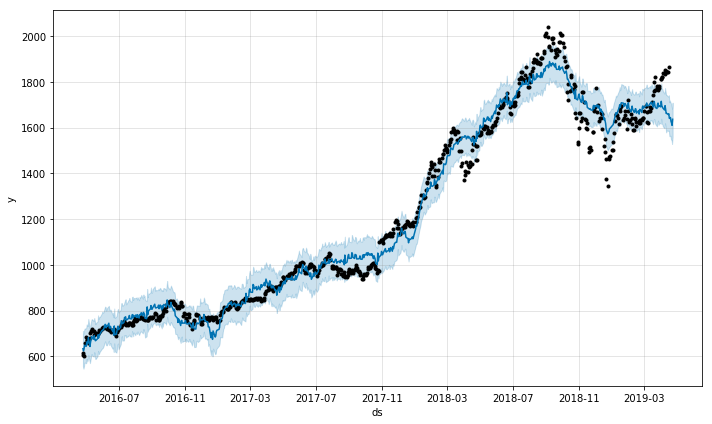

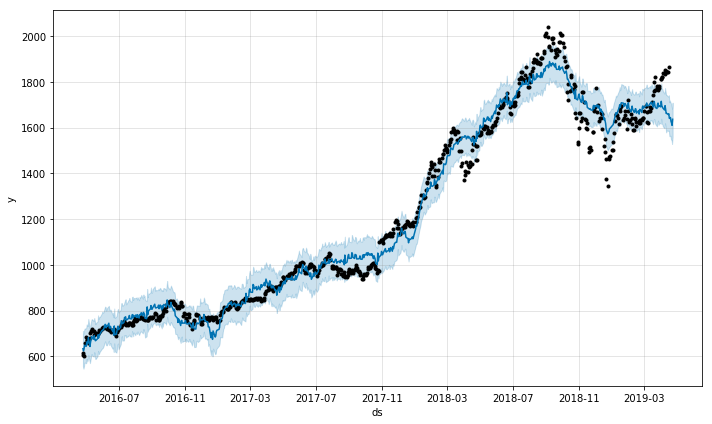

In [64]:
m.plot(forecast)

#### 2. n_changepoints = 9, changepoint_prior_scale = 0.05, seasonality_prior_scale=0.95, fourier_order=20

In [65]:
m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.95, 
            changepoint_prior_scale=0.05, n_changepoints=9, #changepoints=['2019-01-01'], 
            holidays= holidays) # Creating the model 
m.add_seasonality('monthly',period=30.5,fourier_order=20)
m.fit(train) # fit data to model 
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


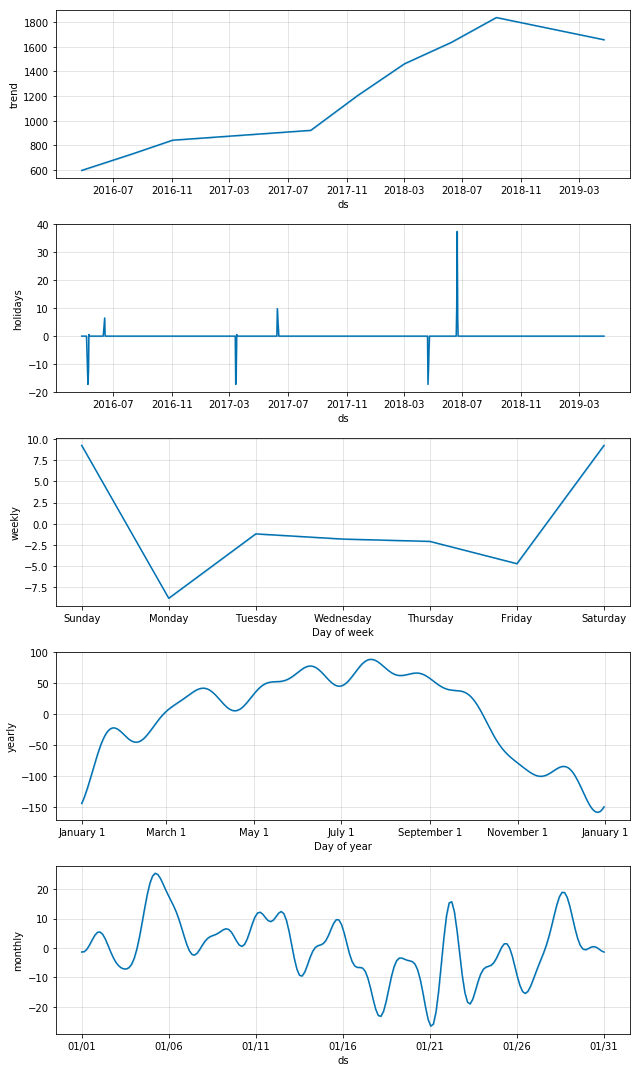

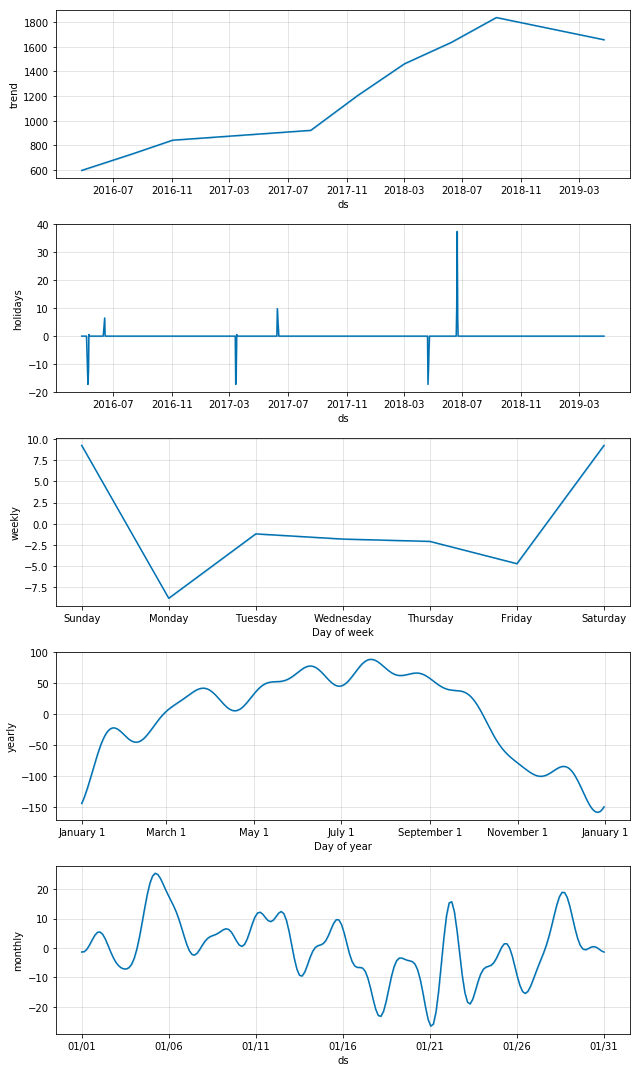

In [66]:
m.plot_components(forecast) # displays the different components

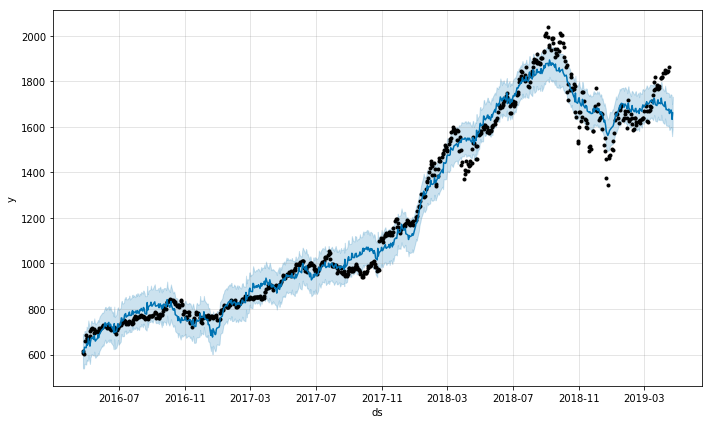

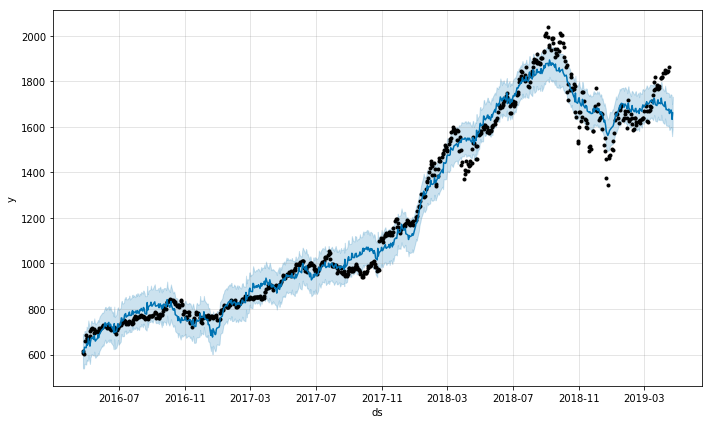

In [67]:
m.plot(forecast)

#### 3. n_changepoints = 9, changepoint_prior_scale = 0.1, seasonality_prior_scale=0.95, fourier_order=20

In [68]:
m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.95, 
            changepoint_prior_scale=0.1, n_changepoints=9, #changepoints=['2019-01-01'], 
            holidays= holidays) # Creating the model 
m.add_seasonality('monthly',period=30.5,fourier_order=20)
m.fit(train) # fit data to model 
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


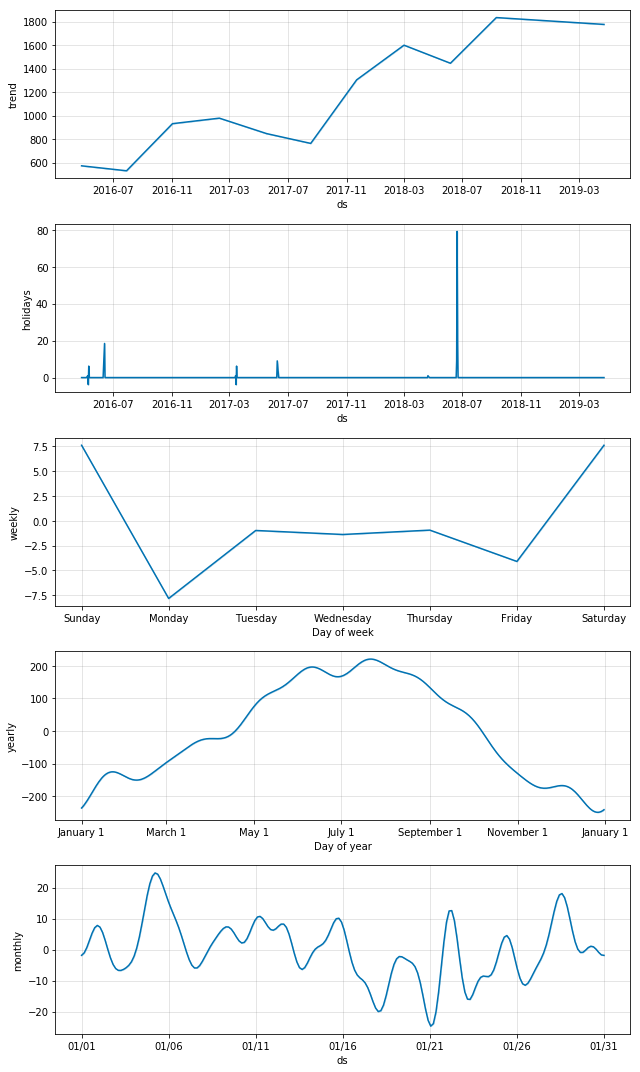

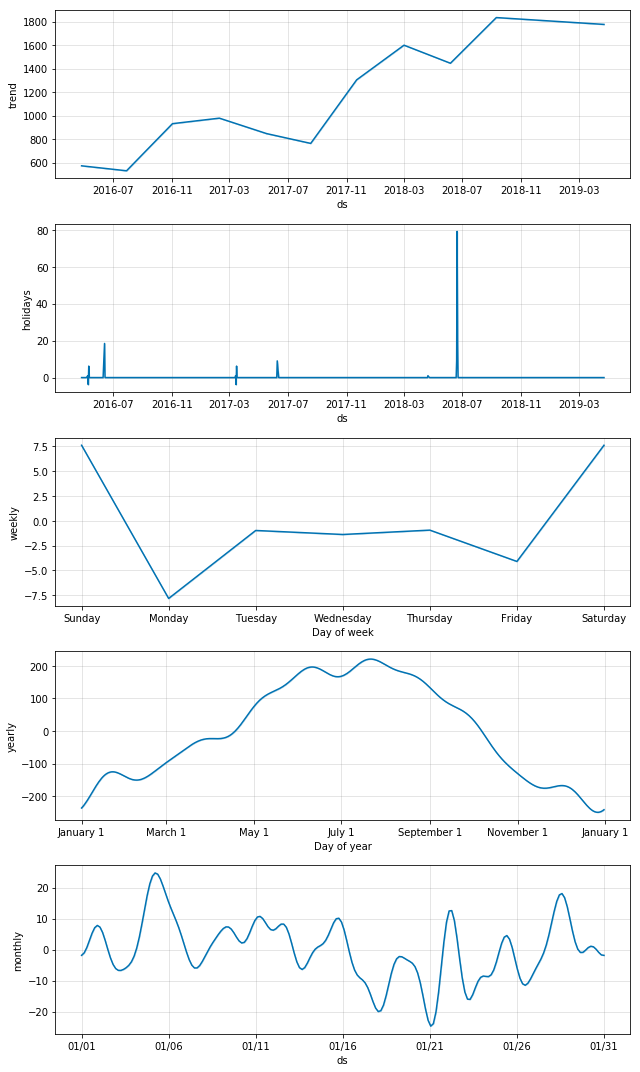

In [69]:
m.plot_components(forecast) # displays the different components

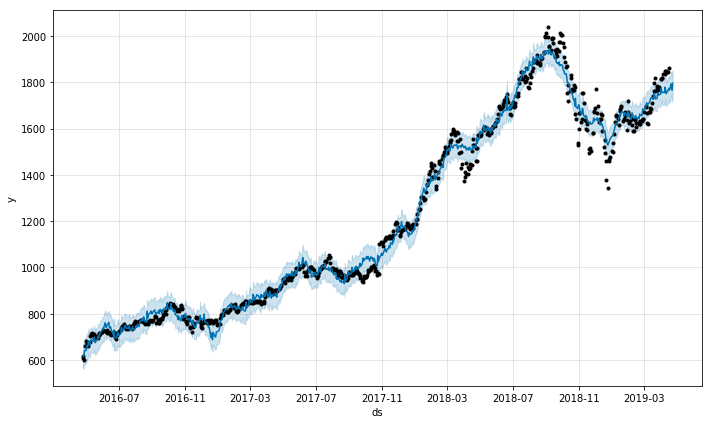

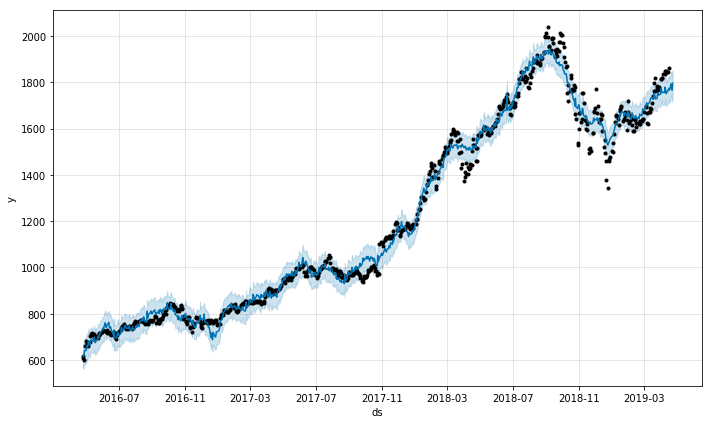

In [70]:
m.plot(forecast)

#### 4. n_changepoints = 15, changepoint_prior_scale = 1.0, seasonality_prior_scale=0.5, fourier_order=13

In [71]:
m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.5, 
            changepoint_prior_scale=1.0, n_changepoints=15, #changepoints=['2019-01-01'], 
            holidays= holidays
           ) # Creating the model 
m.add_seasonality('monthly',period=30.5,fourier_order=13)
m.add_country_holidays(country_name='US')
m.fit(train) # fit data to model 
future = m.make_future_dataframe(periods=7)#it creates  rows 
forecast = m.predict(future) 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


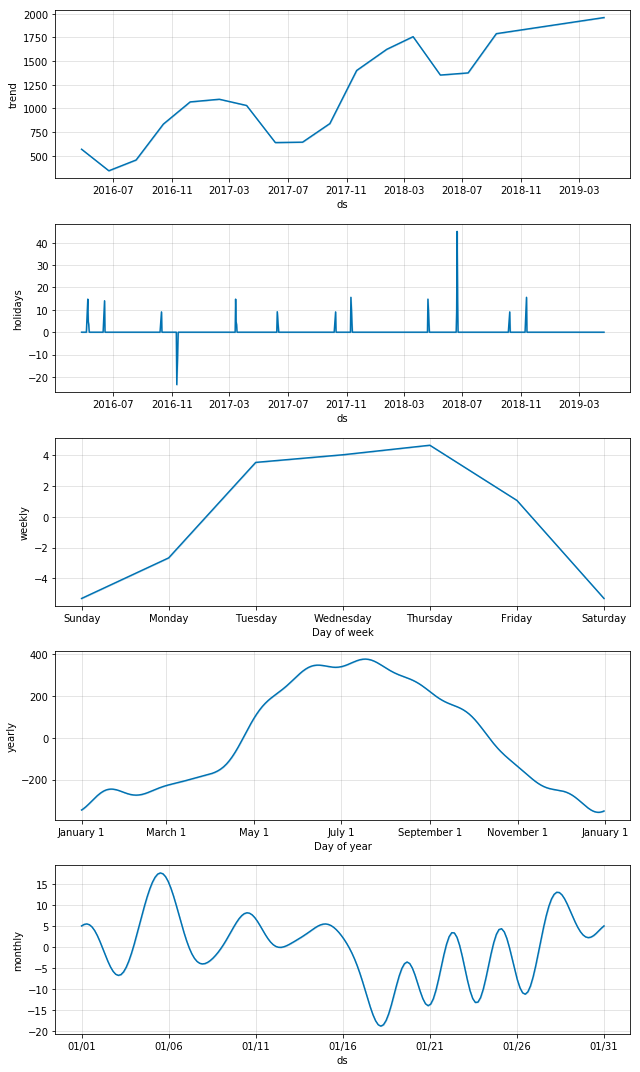

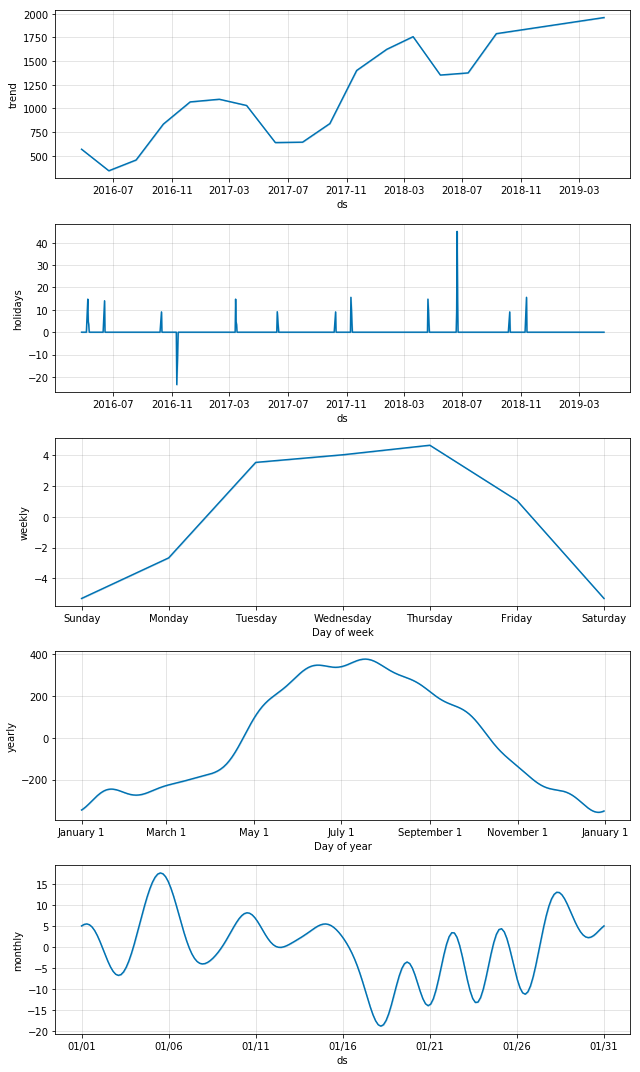

In [72]:
m.plot_components(forecast) # displays the different components

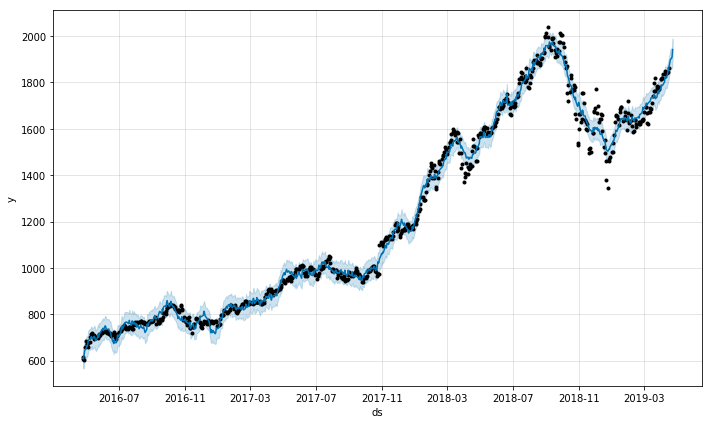

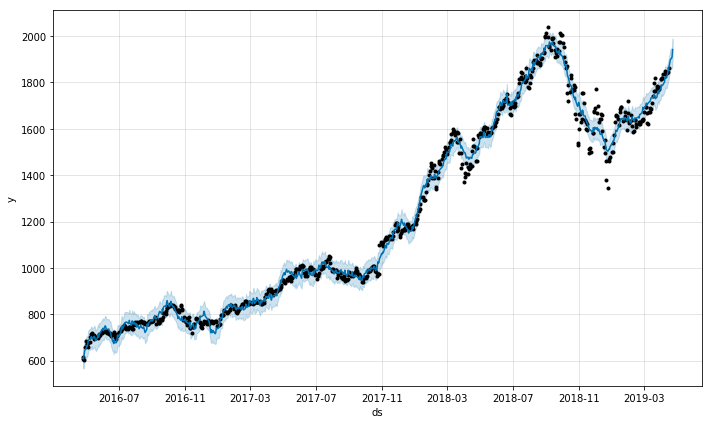

In [73]:
m.plot(forecast)

In [74]:
length = len(ts)

In [75]:
forecast['yhat'][length-7:length]

749    1876.363960
750    1891.026587
751    1900.362191
752    1901.856198
753    1904.496027
754    1911.039247
755    1942.016733
Name: yhat, dtype: float64

So, the following parameters give better forecast for different components:

**n_changepoints = 15, changepoint_prior_scale = 1.0, seasonality_prior_scale=0.5, fourier_order=13**

#### Function for FB Prophet Model with best parameters

In [76]:
def fb(i):
    length = len(data)
    train = data[0:length-i]
    m = Prophet(yearly_seasonality = True, weekly_seasonality= True, seasonality_prior_scale=0.1, 
            changepoint_prior_scale=0.95, n_changepoints=23, #changepoints=['2019-01-01'], 
            holidays= holidays
           ) # Creating the model 
    m.add_seasonality('monthly',period=30.5,fourier_order=15)
    m.add_country_holidays(country_name='US')
    m.fit(train) # fit data to model 
    future = m.make_future_dataframe(periods=i)#it creates  rows 
    forecast = m.predict(future) 
    m.plot(forecast)
    #p_length = len(forecast)
    #a_length = len(data)
    # s_length = length-i
    prediction = forecast['yhat'][length-i:length] #Get values till today
    test = data[length-i:length]
    prediction.index = test.index #set common index
    result = pd.concat([prediction, test.y], axis=1, ignore_index=False) #Concatinate actual and predicted
    result['Date'] = result.index
    result['Actual'] = result['y']
    result['Predicted'] = result['yhat']
    result = result.drop(columns=['yhat','y'])
    result.to_csv('out.csv', index=True, header=True) # export to csv
    print (result)
    return result;

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                 Date       Actual    Predicted
Date                                           
2019-04-17 2019-04-17  1864.819946  1881.963089
2019-04-18 2019-04-18  1861.689941  1885.641000
2019-04-22 2019-04-22  1887.310059  1893.475533
2019-04-23 2019-04-23  1923.770020  1898.392051
2019-04-24 2019-04-24  1901.750000  1895.390760
2019-04-25 2019-04-25  1902.250000  1889.514245
2019-04-26 2019-04-26  1950.630005  1917.812130


,Date,Actual,Predicted
Date,,,
2019-04-17,2019-04-17,1864.819946,1881.963089
2019-04-18,2019-04-18,1861.689941,1885.641000
2019-04-22,2019-04-22,1887.310059,1893.475533
2019-04-23,2019-04-23,1923.770020,1898.392051
2019-04-24,2019-04-24,1901.750000,1895.390760
2019-04-25,2019-04-25,1902.250000,1889.514245
2019-04-26,2019-04-26,1950.630005,1917.812130


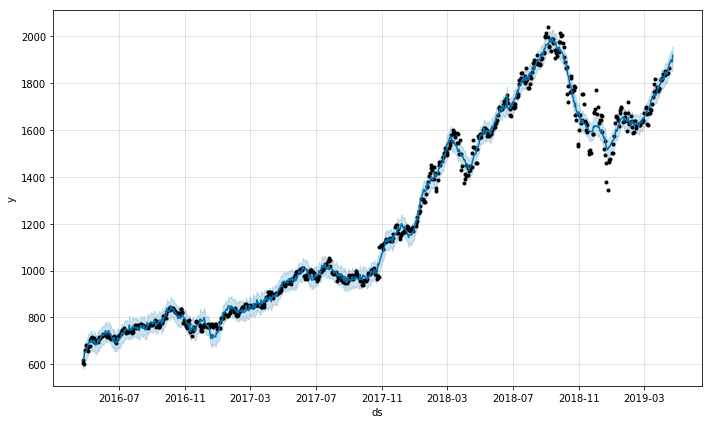

In [77]:
fb(7)

#### Cross Validation

This cross validation procedure can be done automatically for a range of historical cutoffs using the cross_validation function. We specify the forecast horizon (horizon), and then optionally the size of the initial training period (initial) and the spacing between cutoff dates (period). By default, the initial training period is set to three times the horizon, and cutoffs are made every half a horizon.

Here we do cross-validation to assess prediction performance on a horizon of 60 days, starting with 350 days of training data in the first cutoff and then making predictions every 30 days.

In [78]:
from fbprophet.diagnostics import cross_validation

In [79]:
data_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '60 days')

INFO:fbprophet:Making 23 forecasts with cutoffs between 2017-04-26 00:00:00 and 2019-02-15 00:00:00


The output of cross_validation is a dataframe with the true values y and the out-of-sample forecast values yhat

**Obtaining the Performance Metrics**

In [80]:
from fbprophet.diagnostics import performance_metrics

In [81]:
data_p = performance_metrics(data_cv)
data_p.head()

,horizon,mse,rmse,mae,mape,coverage
751,7 days,3855.170429,62.090019,42.535575,0.030878,0.414894
624,7 days,3859.718905,62.126636,42.700915,0.030935,0.414894
910,7 days,3919.662947,62.607212,43.256937,0.031257,0.414894
128,7 days,3971.541667,63.020169,43.740303,0.031865,0.414894
170,7 days,3989.081437,63.159175,44.035739,0.032211,0.404255


The performance_metrics utility can be used to compute some useful statistics of the prediction performance (yhat, yhat_lower, and yhat_upper compared to y), as a function of the distance from the cutoff (how far into the future the prediction was). The statistics computed are mean squared error (MSE), root mean squared error (RMSE), mean absolute error (MAE), mean absolute percent error (MAPE), and coverage of the yhat_lower and yhat_upper estimates. These are computed on a rolling window of the predictions in df_cv after sorting by horizon (ds minus cutoff). 

#### Visualizing Performance Metrics

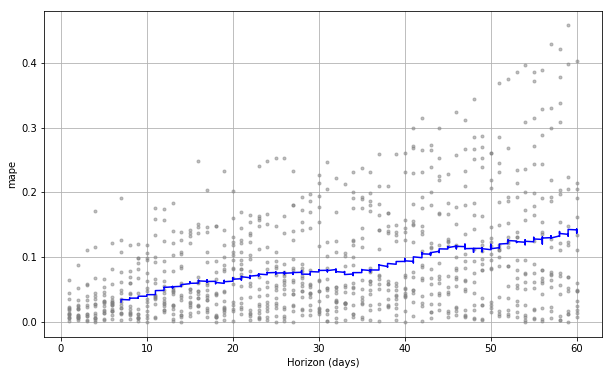

In [83]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(data_cv, metric='mape')

The performance Metrics can be visualized using the plot_cross_validation_metric utility. We visualize the RMSE as shown in the graph.As we have seen Prophet is very powerful and effective in time series forecasting and have given the best predictions with the least amount of errors.

Dots show the absolute percent error for each prediction in data_cv. The blue line shows the MAPE, where the mean is taken over a rolling window of the dots. We see for this forecast that errors around 10% are typical for predictions one month into the future, and that errors increase up to around 25% for predictions that are a year out.

In [124]:
error_7 = data_p[data_p['horizon']=='7 days']
mape = error_7['mape'].mean()
accuracy = 1-mape
print("Accuracy = ",accuracy)

Accuracy =  0.9668668570618081


In [119]:
fbprophet_predictedvsexpected = PrettyTable()

fbprophet_predictedvsexpected.field_names = ["Date", "FbProphet_Predicted","FbProphet_Actual"]

fbprophet_predictedvsexpected.add_row(['2019-04-22',1893.47,1887.31])
fbprophet_predictedvsexpected.add_row(['2019-04-23',1898.39,1923.77])
fbprophet_predictedvsexpected.add_row(['2019-04-24',1895.39,1901.75])
fbprophet_predictedvsexpected.add_row(['2019-04-25',1889.51,1902.25])
fbprophet_predictedvsexpected.add_row(['2019-04-26',1917.81,1946.19])

print(fbprophet_predictedvsexpected)

+------------+---------------------+------------------+
|    Date    | FbProphet_Predicted | FbProphet_Actual |
+------------+---------------------+------------------+
| 2019-04-22 |       1893.47       |     1887.31      |
| 2019-04-23 |       1898.39       |     1923.77      |
| 2019-04-24 |       1895.39       |     1901.75      |
| 2019-04-25 |       1889.51       |     1902.25      |
| 2019-04-26 |       1917.81       |     1946.19      |
+------------+---------------------+------------------+


### Part C

### LSTM

Long Short Term Memory(LSTM) are the most common types of Recurrent Neural Networks used for sequential data. LSTMs have an edge over conventional feed-forward neural networks and RNN in many ways. This is because of their property of selectively remembering patterns for long durations of time.
LSTMs make small modifications to the information by multiplications and additions. With LSTMs, the information flows through a mechanism known as cell states. This way, LSTMs can selectively remember or forget things.

In [90]:
df = df.drop(columns=['Date','ds','y'])
df.head(5)

,Close
Date,
2016-04-26,616.880005
2016-04-27,606.570007
2016-04-28,602.000000
2016-04-29,659.590027
2016-05-02,683.849976
2016-05-03,671.320007
2016-05-04,670.900024
2016-05-05,659.090027
2016-05-06,673.950012


In [93]:
scl = MinMaxScaler(feature_range = (0, 1))
train = scl.fit_transform(df)
train

array([[0.01035124],
       [0.00317911],
       [0.        ],
       [0.04006235],
       [0.05693872],
       [0.04822228],
       [0.04793012],
       [0.03971452],
       [0.05005183],
       [0.05408658],
       [0.07030908],
       [0.07737684],
       [0.08064639],
       [0.07507425],
       [0.07558902],
       [0.06488304],
       [0.06639955],
       [0.06714389],
       [0.07012124],
       [0.06591258],
       [0.07109517],
       [0.07398208],
       [0.07854552],
       [0.07668815],
       [0.08402723],
       [0.08169682],
       [0.08781851],
       [0.08594026],
       [0.08676808],
       [0.0846881 ],
       [0.08670549],
       [0.0874081 ],
       [0.08063246],
       [0.0787751 ],
       [0.08159942],
       [0.07809338],
       [0.08035423],
       [0.07261863],
       [0.07791946],
       [0.07917858],
       [0.07554728],
       [0.08353334],
       [0.06744998],
       [0.06216304],
       [0.07370384],
       [0.07902552],
       [0.07903945],
       [0.086

In [94]:
#Create a function to process the data into 7 day look back slices
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb),0])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)
X,y = processData(train,7)
X_train,X_test = X[:int(X.shape[0]*0.70)],X[int(X.shape[0]*0.70):]
y_train,y_test = y[:int(y.shape[0]*0.70)],y[int(y.shape[0]*0.70):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])

523
225
523
225


In [98]:
#Build the model
model = Sequential()
model.add(LSTM(256,input_shape=(7,1)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
#Reshape data for (Sample,Timestep,Features) 
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=10,validation_data=(X_test,y_test),shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Train on 523 samples, validate on 225 samples
Epoch 1/10
523/523 [==============================] - 2s 3ms/step - loss: 0.0021 - val_loss: 0.0034
Epoch 2/10
523/523 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0094
Epoch 3/10
523/523 [==============================] - 1s 1ms/step - loss: 0.0144 - val_loss: 0.0144
Epoch 4/10
523/523 [==============================] - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0045
Epoch 5/10
523/523 [==============================] - 1s 1ms/step - loss: 0.0063 - val_loss: 0.0020
Epoch 6/10
523/523 [==============================] - 1s 1ms/step - loss: 0.0032 - val_loss: 0.0071
Epoch 7/10
523/523 [==============================] - ETA: 0s - loss: 0.003 - 1s 1ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 8/10
523/523 [==============================] - 1s 1ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 9/10
523/523 [==============================] - 1s 2ms/step - loss: 0.0049 - val_loss: 0.0045
Epoch 10/10
523/523 [=========

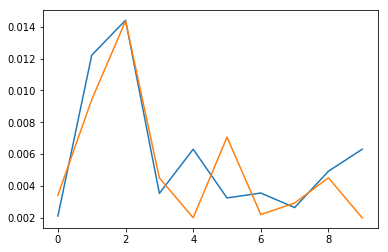

In [99]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

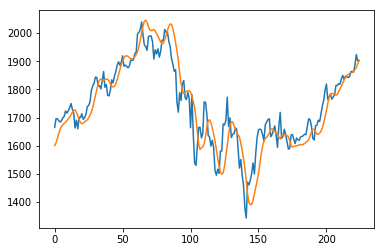

In [100]:
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

In [101]:
act = []
pred = []
#for i in range(225):
i=224
Xt = model.predict(X_test[i].reshape(1,7,1))
#print('predicted:{0}, actual:{1}'.format(scl.inverse_transform(Xt),scl.inverse_transform(y_test[i].reshape(-1,1))))
pred.append(scl.inverse_transform(Xt))
act.append(scl.inverse_transform(y_test[i].reshape(-1,1)))

In [102]:
result_df = pd.DataFrame({'pred':list(np.reshape(pred, (-1))),'act':list(np.reshape(act, (-1)))})

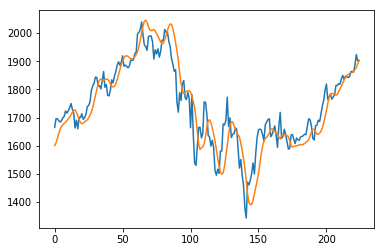

In [103]:
Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)))
plt.plot(scl.inverse_transform(Xt))

In [104]:
actual = scl.inverse_transform(y_test.reshape(-1,1))

In [105]:
pred = scl.inverse_transform(Xt)

In [106]:
index = [str(i) for i in range(0, len(actual))]
act = pd.DataFrame(actual, index=index)
act.columns = ['Actual']

index = [str(i) for i in range(0, len(pred))]
pre = pd.DataFrame(pred, index=index)
pre.columns = ['Predicted']

In [111]:
pre.tail(5)

,Predicted
220,1865.433838
221,1870.625488
222,1877.360840
223,1890.429199
224,1904.372681


In [107]:
import sklearn
from sklearn.metrics import r2_score
sklearn.metrics.r2_score(act, pre, sample_weight=None, multioutput='uniform_average')

0.7829044005114965

In [112]:
lstm_predictedvsexpected = PrettyTable()

lstm_predictedvsexpected.field_names = ["Date", "LSTM_Predicted","LSTM_Actual"]

lstm_predictedvsexpected.add_row(['2019-04-22',1865.43,1887.31])
lstm_predictedvsexpected.add_row(['2019-04-23',1870.62,1923.77])
lstm_predictedvsexpected.add_row(['2019-04-24',1877.36,1901.75])
lstm_predictedvsexpected.add_row(['2019-04-25',1890.42,1902.25])
lstm_predictedvsexpected.add_row(['2019-04-26',1904.37,1946.19])

print(lstm_predictedvsexpected)

+------------+----------------+-------------+
|    Date    | LSTM_Predicted | LSTM_Actual |
+------------+----------------+-------------+
| 2019-04-22 |    1865.43     |   1887.31   |
| 2019-04-23 |    1870.62     |   1923.77   |
| 2019-04-24 |    1877.36     |   1901.75   |
| 2019-04-25 |    1890.42     |   1902.25   |
| 2019-04-26 |    1904.37     |   1946.19   |
+------------+----------------+-------------+


## Final Evaluation Table

In [120]:
evaluation_table = PrettyTable()

evaluation_table.field_names = ["Date","Actual","LSTM_Predicted","FbProphet_Predicted","Arima_Predicted"]

evaluation_table.add_row(['2019-04-22',1887.31,1865.43,1893.47,1861.05])
evaluation_table.add_row(['2019-04-23',1923.77,1870.62,1898.39,1886.67])
evaluation_table.add_row(['2019-04-24',1901.75,1877.36,1895.39,1923.12])
evaluation_table.add_row(['2019-04-25',1902.25,1890.42,1889.51,1901.11])
evaluation_table.add_row(['2019-04-26',1946.19,1904.37,1917.81,1901.61])

print(evaluation_table)

+------------+---------+----------------+---------------------+-----------------+
|    Date    |  Actual | LSTM_Predicted | FbProphet_Predicted | Arima_Predicted |
+------------+---------+----------------+---------------------+-----------------+
| 2019-04-22 | 1887.31 |    1865.43     |       1893.47       |     1861.05     |
| 2019-04-23 | 1923.77 |    1870.62     |       1898.39       |     1886.67     |
| 2019-04-24 | 1901.75 |    1877.36     |       1895.39       |     1923.12     |
| 2019-04-25 | 1902.25 |    1890.42     |       1889.51       |     1901.11     |
| 2019-04-26 | 1946.19 |    1904.37     |       1917.81       |     1901.61     |
+------------+---------+----------------+---------------------+-----------------+


In [122]:
Accuracy_table = PrettyTable()

Accuracy_table.field_names = ["LSTM_Accuracy","FbProphet_Accuracy","Arima_Accuracy"]
Accuracy_table.add_row([78.29,96.5,91.8])
print(Accuracy_table)

+---------------+--------------------+----------------+
| LSTM_Accuracy | FbProphet_Accuracy | Arima_Accuracy |
+---------------+--------------------+----------------+
|     78.29     |        96.5        |      91.8      |
+---------------+--------------------+----------------+



### Conclusion

Predicting stock market prices is really a difficult task, as the market keeps changing continuously with time following a trend based on various factors. 
All Stock market data are a time series problem and we have analysed and transformed our Amazon stock price data treating its seasonality and trend as these affect the prediction.
We have modelled a ML algorithm called ARIMA(Auto-Regressive Integrated Moving Average) to forecast the stock market prices and tuned the hyper parameters to get a model that predicts with better accuracy.
